In [60]:
import pandas as pd
import numpy as np
import os
import os.path as osp
import sys
sys.path.append('../../scripts')
import featurizer
sys.path.append('../../../../../scripts/preprocessing')
import preprocessing
import torch
from tqdm.notebook import tqdm
import warnings
from torch import nn
from typing import Union,Optional
from torch import Tensor
from torch.utils.data import DataLoader
from typing import List
import matplotlib.pyplot as plt

In [2]:
df_btc = preprocessing.load_df('../../../../../../data/Binance/BTC_USDT.csv')

warnings.filterwarnings('ignore')

path_btc = '../../../../../../data/data_new/raw/Binance/BTC_USDT/BTC_USDT.csv'

df_btc_feat = featurizer.load_and_featurize(path_btc)

Total NaN : 

timestamp    0
open         0
high         0
low          0
close        0
volume       0
returns      1
dtype: int64

Total NaN : 

timestamp    0
open         0
high         0
low          0
close        0
volume       0
returns      1
dtype: int64



  0%|          | 0/1811 [00:00<?, ?it/s]

We make use of 90.44726670347875% of the data


0it [00:00, ?it/s]

In [3]:
from torch.utils.data import Dataset

class twoday_basic_dset(Dataset):
    
    def __init__(self,df):
        self.X = torch.tensor(df.X.tolist(),dtype = torch.float)
        self.y = torch.tensor(df.y.astype(int).tolist(),dtype = torch.float)
        
    def __getitem__(self,
                    index: int):
        return (self.X[index],self.y[index])
    
    def __len__(self):
        return len(self.X)

In [4]:
class MLP(nn.Module):
    def __init__(
        self,
        embed_dims: Union[int, list],
        num_layers: Optional[int] = None,
        activation: str = "relu",
    ) -> None:
        super().__init__()

        if isinstance(embed_dims, int):
            assert num_layers is not None
            embed_dims = [embed_dims] * num_layers
        else:
            assert num_layers is None
            num_layers = len(embed_dims)

        assert activation == "relu"

        self.embed_dims = embed_dims
        self.num_layers = num_layers
        self.activation = activation

        self.layers = nn.ModuleList(
            [
                sublayer
                for i, (m, n) in enumerate(zip(embed_dims, embed_dims[1:]))
                for sublayer in [nn.Linear(m, n), nn.BatchNorm1d(n), nn.ReLU()]
                if not (i == num_layers - 2 and isinstance(sublayer, nn.ReLU))
            ]
        )


    def forward(self, x: Tensor) -> Tensor:
        for layer in self.layers:
            x = layer(x)
        return x

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [80]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch.loggers import CSVLogger
import torchmetrics as tm
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks.early_stopping import EarlyStopping




class MLP_binary_classifier(pl.LightningModule):
    
    def __init__(self,
                 embed_dims: List[int],
                 lr = 0.001):
        super().__init__()
        self.mlp = MLP(embed_dims)
        self.Classifier_head = nn.Linear(embed_dims[-1],1)
        self.s = nn.Sigmoid()
        self.step_outputs = {"train": [],"val":[],"test":[]}
        self.average_precision = tm.AveragePrecision(task = 'binary')
        self.auroc = {name : tm.AUROC(task = 'binary') for name in ['train','val']}
        self.lr = lr
        self.pr_curve = tm.PrecisionRecallCurve(task="binary")
        
    def forward(self,
                batch):
        
        x,y = batch
        x = self.mlp(x)
        x = self.Classifier_head(x)
        x = self.s(x)
        
        return x
          
    def _step(self,
              name: str,
              batch: List[torch.tensor]):
        
        target = batch[1].to(device)
        predicted_proba = self.forward(batch).flatten()
        criterion = nn.BCELoss()
        loss = criterion(predicted_proba,target)
        self.step_outputs[name].append({"loss": loss, "predicted_proba": predicted_proba, "target": batch[1]})
        
        self.log(
            f"{name}/loss", loss, prog_bar = True, on_epoch=True, logger = True, on_step= (name=="train"), batch_size=batch[1].shape[0]
        )
        
        if name == 'val':
            x = target.type(torch.int)
            self.average_precision(predicted_proba,x)
            self.log("val/average_precision",self.average_precision,on_epoch = True,on_step = False)
        
        
        self.pr_curve.update(predicted_proba,target.type(torch.int))
        
        return {"loss": loss, "predicted_proba": predicted_proba, "target": batch[1]}
    
    def training_step(self, batch, batch_idx = None):
        return self._step("train", batch)
    
    def validation_step(self, batch, batch_idx = None):
        return self._step("val", batch)
    
    #def _epoch_end(self, name):
    #    y = torch.hstack([output["target"] for output in self.step_outputs[name]])
    #    y = y.type(torch.long)
    #    print(y)
    #    preds = torch.hstack([output["predicted_proba"] for output in self.step_outputs[name]])
    #    print(preds) 
    
        #self.log(f"{name}/auroc", self.auroc[name])
        #self.log(f"{name}/average_precision", tm.binary_average_precision(preds, y))

        #precision, recall, _ = tm.binary_precision_recall_curve(preds, y)
        #for ten_x in range(1,11):
        #    x = ten_x / 10
        #    if compute_p_at_r(precision, recall, x) != None:
        #        self.log(f"{name}/p@r={x}", compute_p_at_r(precision, recall, x))
#
        #    y_pred = (preds > x).long()
        #    self.log(f"{name}/accuracy@thh={x}", tm.binary_accuracy(y_pred, y))
        #    self.log(f"{name}/recall@thh={x}", tm.binary_recall(y_pred, y))
        #    self.log(f"{name}/precision@thh={x}", tm.binary_precision(y_pred, y))
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer  
    
    #def on_training_epoch_end(self):
    #    outputs = self.step_outputs['train']
    #    return self._epoch_end("train")
    #
    
    def on_validation_epoch_end(self):
        outputs = self.step_outputs['val']
        precision,recall,thresh = self.pr_curve.compute()
        
        a1 = precision[recall >= 0.25][-1]
        a2 = precision[recall >= 0.5][-1]
        a3 = precision[recall >= 0.75][-1]
        
        self.log("val/p@r=0.25",a1)
        self.log("val/p@r=0.5",a2)
        self.log("val/p@r=0.75",a3)
        
        self.pr_curve.reset()
        
        #return self._epoch_end("val")
    
    #def train_dataloader(self):
    #    dloader = dd.get_dataloader(self.batch_size,self.trainset,self.esm_feat,is_inference = False)
    #    return dloader
    #
    #def val_dataloader(self):
    #    dloader = dd.get_dataloader(self.batch_size,self.valset,self.esm_feat,is_inference = True)
    #    return dloader
            

In [81]:
#class MyCallback(pl.Callback):
#    
#    def on_x_epoch_end(self, name, pl_module):
#        # do something with all training_step outputs, for example:
#        epoch_mean = torch.stack(pl_module.step_outputs[name]).mean()
#        pl_module.log(f"{name}_epoch_mean", epoch_mean)
#        # free up the memory
#        pl_module.step_outputs[name].clear()
#        
#    def on_train_epoch_end(self, trainer, pl_module):
#        return self.on_x_epoch_end("train", pl_module)
#        
#    def on_validation_epoch_end(self, trainer, pl_module):
#        return self.on_x_epoch_end("val", pl_module)

In [82]:
def get_dloader(df,
                batch_size,
                num_workers = 64,
                shuffle = True):
    
    dset = twoday_basic_dset(df)
    dloader = DataLoader(dset,batch_size = batch_size,num_workers = num_workers, shuffle = shuffle)
    
    return dloader

In [83]:
train_df = df_btc_feat[:int(0.6*len(df_btc_feat))]
val_df = df_btc_feat[int(0.62*len(df_btc_feat)):int(0.75*len(df_btc_feat))]
test_df = df_btc_feat[int(0.75*len(df_btc_feat)):]

train_loader = get_dloader(train_df,16,64,True)
val_loader =  get_dloader(val_df,1024,64,True)
test_df = get_dloader(test_df,256,64,True)

In [90]:
model = MLP_binary_classifier([124,64,16])

In [91]:
early_stop_callback = EarlyStopping(monitor="val/p@r=0.25", min_delta=0.01, patience=5, verbose=False, mode="max")



In [92]:
trainer = pl.Trainer(accelerator="gpu",callbacks = [early_stop_callback])
trainer.fit(model,train_loader,val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type                       | Params
-----------------------------------------------------------------
0 | mlp               | MLP                        | 9.2 K 
1 | Classifier_head   | Linear                     | 17    
2 | s                 | Sigmoid                    | 0     
3 | average_precision | BinaryAveragePrecision     | 0     
4 | pr_curve          | BinaryPrecisionRecallCurve | 0     
-----------------------------------------------------------------
9.2 K     Trainable params
0         Non-trainable params
9.2 K     Total params
0.037     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [93]:
metrics = pd.read_csv('./lightning_logs/version_14/metrics.csv')

In [94]:
metrics.dropna(subset = ['val/average_precision'])

,train/loss_step,epoch,step,val/loss,val/average_precision,val/p@r=0.25,val/p@r=0.5,val/p@r=0.75,train/loss_epoch
1,NaN,0,61,0.493634,0.870439,0.832727,0.801754,0.776018,NaN
4,NaN,1,123,0.541548,0.860975,0.864151,0.820467,0.793981,NaN
7,NaN,2,185,0.491414,0.866002,0.848148,0.811723,0.804220,NaN
10,NaN,3,247,0.620311,0.843042,0.826715,0.827899,0.784000,NaN
14,NaN,4,309,0.582050,0.838700,0.874046,0.844732,0.805164,NaN
17,NaN,5,371,0.532204,0.860846,0.884170,0.840074,0.799534,NaN
20,NaN,6,433,0.536832,0.857549,0.877395,0.836996,0.811834,NaN
23,NaN,7,495,0.636774,0.875889,0.851301,0.841621,0.810875,NaN
27,NaN,8,557,0.637672,0.835100,0.884170,0.841621,0.817640,NaN
30,NaN,9,619,0.573073,0.843894,0.916000,0.854206,0.813760,NaN


In [39]:
batch = next(iter(val_loader))

pr_curve = tm.PrecisionRecallCurve(task="binary")

In [41]:
pred = model(batch)

In [48]:
pred = pred.flatten()
target = batch[1]

target = target.type(torch.int)

In [50]:
precision,recall,threshold = pr_curve(pred,target)

In [54]:
precision[recall > 0.1]

tensor([0.8169, 0.8160, 0.8152, 0.8190, 0.8230, 0.8221, 0.8213, 0.8204, 0.8195,
        0.8186, 0.8177, 0.8168, 0.8159, 0.8150, 0.8141, 0.8131, 0.8122, 0.8112,
        0.8103, 0.8093, 0.8083, 0.8073, 0.8063, 0.8053, 0.8095, 0.8085, 0.8075,
        0.8065, 0.8054, 0.8043, 0.8087, 0.8077, 0.8066, 0.8056, 0.8045, 0.8034,
        0.8023, 0.8068, 0.8057, 0.8046, 0.8092, 0.8081, 0.8070, 0.8059, 0.8047,
        0.8036, 0.8024, 0.8072, 0.8061, 0.8110, 0.8098, 0.8086, 0.8137, 0.8125,
        0.8176, 0.8165, 0.8153, 0.8141, 0.8194, 0.8247, 0.8235, 0.8224, 0.8278,
        0.8267, 0.8255, 0.8243, 0.8231, 0.8219, 0.8207, 0.8194, 0.8252, 0.8239,
        0.8298, 0.8286, 0.8345, 0.8333, 0.8321, 0.8309, 0.8296, 0.8284, 0.8271,
        0.8258, 0.8244, 0.8231, 0.8217, 0.8203, 0.8268, 0.8254, 0.8240, 0.8226,
        0.8211, 0.8197, 0.8182, 0.8250, 0.8235, 0.8220, 0.8205, 0.8190, 0.8174,
        0.8158, 0.8142, 0.8125, 0.8108, 0.8091, 0.8073, 0.8056, 0.8131, 0.8113,
        0.8190, 0.8173, 0.8252, 0.8235, 

In [63]:
precision[recall > 0.7][-1]

tensor(0.8243)

In [56]:
recall

tensor([1.0000, 0.9943, 0.9885, 0.9885, 0.9885, 0.9828, 0.9770, 0.9713, 0.9655,
        0.9598, 0.9540, 0.9483, 0.9425, 0.9368, 0.9310, 0.9253, 0.9195, 0.9138,
        0.9080, 0.9023, 0.8966, 0.8908, 0.8851, 0.8793, 0.8793, 0.8736, 0.8678,
        0.8621, 0.8563, 0.8506, 0.8506, 0.8448, 0.8391, 0.8333, 0.8276, 0.8218,
        0.8161, 0.8161, 0.8103, 0.8046, 0.8046, 0.7989, 0.7931, 0.7874, 0.7816,
        0.7759, 0.7701, 0.7701, 0.7644, 0.7644, 0.7586, 0.7529, 0.7529, 0.7471,
        0.7471, 0.7414, 0.7356, 0.7299, 0.7299, 0.7299, 0.7241, 0.7184, 0.7184,
        0.7126, 0.7069, 0.7011, 0.6954, 0.6897, 0.6839, 0.6782, 0.6782, 0.6724,
        0.6724, 0.6667, 0.6667, 0.6609, 0.6552, 0.6494, 0.6437, 0.6379, 0.6322,
        0.6264, 0.6207, 0.6149, 0.6092, 0.6034, 0.6034, 0.5977, 0.5920, 0.5862,
        0.5805, 0.5747, 0.5690, 0.5690, 0.5632, 0.5575, 0.5517, 0.5460, 0.5402,
        0.5345, 0.5287, 0.5230, 0.5172, 0.5115, 0.5057, 0.5000, 0.5000, 0.4943,
        0.4943, 0.4885, 0.4885, 0.4828, 

In [61]:
p = precision.cpu().numpy()

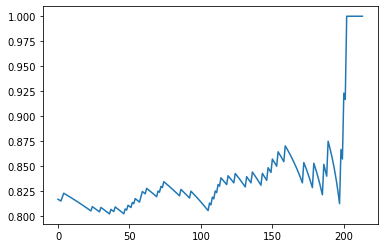

In [62]:
plt.plot(p)